<a href="https://colab.research.google.com/github/Thomas-Schrder/Bachelor-Project/blob/main/BachelorML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from mlxtend.frequent_patterns import apriori, association_rules
import warnings

# Suppress specific deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pexpect")
# Suppress specific deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="ipykernel")

# Enabelling the LabelEncoder
le = LabelEncoder()

from google.colab import drive # Gets my data stored in the cloud
drive.mount("/content/drive")

# Libraries imported, if imported correctly the below will print
print("Libraries imported.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Libraries imported.


In [ ]:
# Data set upload
filepath = "/content/drive/MyDrive/Bachelor/Data/online_retail_10_11.csv"

In [ ]:
# I needed the below code to figure ut why it wsa not working
"""
# Library called Chardent to detect the encoding
import chardet

# Opens the file in binary
with open(filepath, "rb") as f:
    result = chardet.detect(f.read())

# Prints encoding value
print(result["encoding"])
"""

'\n# Library called Chardent to detect the encoding\nimport chardet\n\n# Opens the file in binary\nwith open(filepath, "rb") as f:\n    result = chardet.detect(f.read())\n\n# Prints encoding value\nprint(result["encoding"])\n'

In [ ]:
# First look at the dataset
df = pd.read_csv(filepath, encoding='utf-8-sig') # Encoding as would not open
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/Bachelor/Data/online_retail_10_11.csv'  # Adjust the path as necessary
df = pd.read_csv(file_path, encoding='utf-8-sig')

# Initial look at the data types
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   UnitPrice    541910 non-null  float64
 6   CustomerID   406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# Turns columns to datetime data type
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Seperate date column
df["Date"] = df["InvoiceDate"].dt.date

# Time column
df["InvoiceTime"] = df["InvoiceDate"].dt.time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   UnitPrice    541910 non-null  float64       
 6   CustomerID   406830 non-null  float64       
 7   Country      541910 non-null  object        
 8   Date         541910 non-null  object        
 9   InvoiceTime  541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 41.3+ MB


In [ ]:
# convert column from object to string
df["Description"] = df["Description"].astype(str)

# Storing rows with words found thorught the project that are not product sales
remove_words = ["AMAZON FEE", "Manual", "Adjust bad debt", "Bank Charges", "CRUK Commission", "Discount", "SAMPLES"]

# Boolean indexing to drop rows containing specific words
df = df[~df["Description"].str.contains("|".join(remove_words))]

df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134848
Country             0
Date                0
InvoiceTime         0
dtype: int64

In [ ]:
# Have a total order column by multiplying the quantity by unit price
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,InvoiceTime,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34


In [ ]:

# Missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134848
Country             0
Date                0
InvoiceTime         0
TotalPrice          0
dtype: int64

In [ ]:
# Checking the df
df.describe()


,Quantity,UnitPrice,CustomerID,TotalPrice
count,541108.000000,541108.000000,406260.000000,541108.000000
mean,9.562962,3.737137,15287.823793,18.615276
std,218.204814,23.313718,1713.519163,367.079634
min,-80995.000000,0.000000,12346.000000,-168469.600000
25%,1.000000,1.250000,13954.000000,3.400000
50%,3.000000,2.080000,15152.000000,9.750000
75%,10.000000,4.130000,16791.000000,17.400000
max,80995.000000,8142.750000,18287.000000,168469.600000


In [ ]:
# Assuming that minus values are refunds
print(df[df["Quantity"] < 0])

       InvoiceNo StockCode                        Description  Quantity  \
154      C536383    35004C    SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556     PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984   PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983   PACK OF 12 BLUE PAISLEY TISSUES        -24   
238      C536391     21980  PACK OF 12 RED RETROSPOT TISSUES        -24   
...          ...       ...                                ...       ...   
540448   C581490     22178    VICTORIAN GLASS HANGING T-LIGHT       -12   
540449   C581490     23144    ZINC T-LIGHT HOLDER STARS SMALL       -11   
541715   C581568     21258         VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978   HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979      36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice  CustomerID         Country        Date  \
154    2010-12-01 

In [ ]:
# Need to reference/ If quantity is negative, it is a returned or cancelled item
df["Transaction Type"] = np.where(df["Quantity"] < 0, "Cancelled", "Sale")

# Print the resulting dataframe
print(df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   
541909    581587      POST                              POSTAGE         1   

               InvoiceDate  UnitPrice  CustomerID         Country        Da

In [ ]:
#@title Duplicates
# If row duplicated store here
Duplicates = df[df.duplicated(keep=False)]

# If statement which shows
if len(Duplicates) > 0:
  # Prints the length or count of duplicate rows
    print("Total count of duplicate rows:", len(Duplicates))
# If all duplicates missing or now deleted will show no duplicate found
else:
    print("No duplicate rows found.")


# Droppin doubles
df = df.drop_duplicates()

# DOne again to check if deleted now
Duplicates2 = df[df.duplicated(keep=False)]

# If statement which shows
if len(Duplicates2) > 0:
  # Prints the length or count of duplicate rows
    print("Total count of duplicate rows:", len(Duplicates2))
# If all duplicates missing or now deleted will show no duplicate found
else:
    print("No duplicate rows found, they have now been deleted.")

Total count of duplicate rows: 10139
No duplicate rows found, they have now been deleted.


In [ ]:
#@title Start/End Date
# Looking for start and end date in df
StartDate = (df["InvoiceDate"].min())
EndDate = (df["InvoiceDate"].max())
print("Start date of data set: ", StartDate)
print("End date of data set: ", EndDate)


Start date of data set:  2010-12-01 08:26:00
End date of data set:  2011-12-09 12:50:00


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,535846.000000,535846.000000,401040.000000,535846.000000
mean,9.631286,3.750109,15281.278104,18.758158
std,219.254795,23.426468,1713.915953,368.867735
min,-80995.000000,0.000000,12346.000000,-168469.600000
25%,1.000000,1.250000,13939.000000,3.750000
50%,3.000000,2.080000,15145.000000,9.870000
75%,10.000000,4.130000,16788.000000,17.400000
max,80995.000000,8142.750000,18287.000000,168469.600000


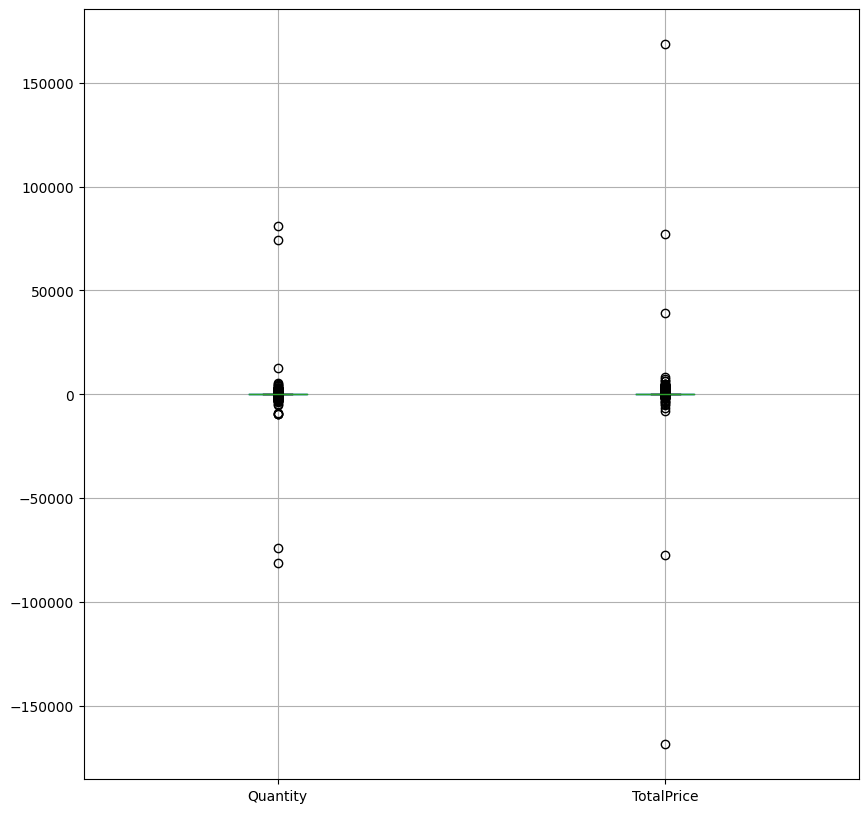

In [ ]:
# Locating outliers throuhg a box plot, on colu,n qunatity by price
df.loc[:, ["Quantity", "TotalPrice"]].boxplot(figsize = (10,10));

In [ ]:
# Function with some pre argumetns inside
def remove_outliers(data, lower_percentile = 0.25, upper_percentile = 0.75):
  # Defining Q's
    q1 = data.quantile(lower_percentile)
    q3 = data.quantile(upper_percentile)
    # Finding the inter quartile range
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Checks if data is in side the quartile range and stored
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    return filtered_data

In [ ]:
# Outliers removed for quantity
df.Quantity = remove_outliers(df.Quantity)
# Outliers removed for price
df.Revenue = remove_outliers(df.TotalPrice)
df.dropna(inplace=True)
df.loc[:, ["Quantity", "TotalPrice"]].describe()

<ipython-input-179-6ccaabdf0e46>:4: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



,Quantity,TotalPrice
count,345679.000000,345679.000000
mean,5.451795,12.901467
std,4.772567,26.123126
min,-12.000000,-8142.750000
25%,2.000000,3.750000
50%,4.000000,10.000000
75%,10.000000,17.340000
max,23.000000,8142.750000


# Weather API connected

In [ ]:
# The weather API to link the histprical weather data
Base_URL = "http://api.openweathermap.org/data/2.5/weather?"
API_Key = "1e81f8cce84f885d279386c4a8f53d23"
CITY = "London"

# Created URL to call
url = Base_URL + "appid=" + API_Key + "&q=" + CITY
# Data stored in JSON
APIjson = requests.get(url).json()

print(APIjson)

{'coord': {'lon': -0.1257, 'lat': 51.5085}, 'weather': [{'id': 801, 'main': 'Clouds', 'description': 'few clouds', 'icon': '02d'}], 'base': 'stations', 'main': {'temp': 280.12, 'feels_like': 278.33, 'temp_min': 278.01, 'temp_max': 281.79, 'pressure': 1009, 'humidity': 81}, 'visibility': 10000, 'wind': {'speed': 2.57, 'deg': 330}, 'clouds': {'all': 20}, 'dt': 1701174300, 'sys': {'type': 2, 'id': 2075535, 'country': 'GB', 'sunrise': 1701157146, 'sunset': 1701187076}, 'timezone': 0, 'id': 2643743, 'name': 'London', 'cod': 200}


In [ ]:
# Function the turns weather to calsius
def kelvin2celsius(kelvin):
  celsius = kelvin - 273.15
  return celsius

In [ ]:
# Temp is in kelvin so turned it into celsius
temp_kelvin = APIjson ["main"]["temp"]
temp_celsius = kelvin2celsius(temp_kelvin)
feels_like_kelvin = APIjson ["main"]["feels_like"]
feels_like_celsius = kelvin2celsius(feels_like_kelvin)
# Description is the weather description which could be important
description = APIjson["weather"][0]["description"]

# Prints results
print(f"Current temperature in {CITY}: {temp_celsius:.2f} C")
print(f"Current temperature in {CITY} feels like: {feels_like_celsius:.2f} C")
print(f"General Weather in {CITY}: {description}")

Current temperature in London: 6.97 C
Current temperature in London feels like: 5.18 C
General Weather in London: few clouds


In [ ]:
# Shows available API keys
APIjson.keys()

dict_keys(['coord', 'weather', 'base', 'main', 'visibility', 'wind', 'clouds', 'dt', 'sys', 'timezone', 'id', 'name', 'cod'])

In [ ]:
# The two I will use look at type to convert to df
print("Data type for main is: ", type(APIjson["main"]))
print("Data type for weather is: ", type(APIjson["weather"]))
print("Data type for dt is: ", type(APIjson["dt"]))


Data type for main is:  <class 'dict'>
Data type for weather is:  <class 'list'>
Data type for dt is:  <class 'int'>


In [ ]:
# Convert to df
TestDf = pd.DataFrame(APIjson["main"], index = [0])
TestDf

,temp,feels_like,temp_min,temp_max,pressure,humidity
0,280.12,278.33,278.01,281.79,1009,81


In [ ]:
"""
 # Getting the wanted weather data from he Json data
weather_data = {"Temperature": kelvin2celsius(APIjson["main"]["temp"]),
  "Feels Like": kelvin2celsius(APIjson["main"]["feels_like"]),
  "Min Temperature": kelvin2celsius(APIjson["main"]["temp_min"]),
  "Max Temperature": kelvin2celsius(APIjson["main"]["temp_max"])}

# Adds the weather data to the df
WeatherDF = df.append(weather_data, ignore_index=True)
WeatherDF
"""


'\n # Getting the wanted weather data from he Json data\nweather_data = {"Temperature": kelvin2celsius(APIjson["main"]["temp"]),\n  "Feels Like": kelvin2celsius(APIjson["main"]["feels_like"]),\n  "Min Temperature": kelvin2celsius(APIjson["main"]["temp_min"]),\n  "Max Temperature": kelvin2celsius(APIjson["main"]["temp_max"])}\n\n# Adds the weather data to the df\nWeatherDF = df.append(weather_data, ignore_index=True)\nWeatherDF\n'

In [ ]:
# Would not work no matter what, tired batch processing, found out after that there is a max number of reuqests.


# Data analysis

## Data analysis (Product)

In [ ]:
#@title Country Sales
import plotly.express as px

# New Country df with columns for the graph
CountryDF = df[["Country", "Quantity", "TotalPrice"]]

# Grouping all countries to see the biggest buyers with.sum()
CountryDFgrouped = CountryDF.groupby("Country").sum()

# Top 20 countries based on Quantity
CountryDFquantity = CountryDFgrouped.sort_values("Quantity", ascending = False).head(20)

# Bar chart for Quantity on x and country on y axis using Plotly made horizontal
fig_quantity = px.bar(CountryDFquantity, x = "Quantity", y = CountryDFquantity.index,
                      orientation = "h", labels={"Quantity": "Quantity Sold", "y": "Country"}, title = "Top 20 Countries by Quantity Sold")

# Adding in colour code for graph
fig_quantity.update_traces(marker = dict(color = px.colors.sequential.Oranges))

fig_quantity.show()

# top 20 countries based on Total Price
CountryDFprice = CountryDFgrouped.sort_values("TotalPrice", ascending = False).head(20)

# Bar chart for Total Price on x and country on y axis using Plotly made horizontal
fig_price = px.bar(CountryDFprice, x = "TotalPrice", y = CountryDFprice.index, orientation="h",
                   labels={"TotalPrice": "Total Price", "y": "Country"}, title = "Top 20 Countries by Total Price")

# Adding in colour code for graph
fig_price.update_traces(marker = dict(color = px.colors.sequential.Oranges))

fig_price.show()


Top 25 best-selling products:
                                    TotalPrice  Quantity  UnitPrice
Description                                                        
REGENCY CAKESTAND 3 TIER              81409.30    6857.0  11.872437
POSTAGE                               66728.24    3003.0  22.220526
PARTY BUNTING                         32599.83    6599.0   4.940117
WHITE HANGING HEART T-LIGHT HOLDER    29075.56    9860.0   2.948840
JUMBO BAG RED RETROSPOT               24644.90   12025.0   2.049472
SPOTTY BUNTING                        22169.05    4483.0   4.945137
DOORMAT KEEP CALM AND COME IN         21006.34    2801.0   7.499586
JAM MAKING SET WITH JARS              18769.74    4581.0   4.097302
SET OF 3 CAKE TINS PANTRY DESIGN      17552.48    3546.0   4.949938
ASSORTED COLOUR BIRD ORNAMENT         17197.44   10176.0   1.690000
DOORMAT RED RETROSPOT                 16431.93    2243.0   7.325872
NATURAL SLATE HEART CHALKBOARD        16333.37    5463.0   2.989817
WOOD BLACK BOARD A

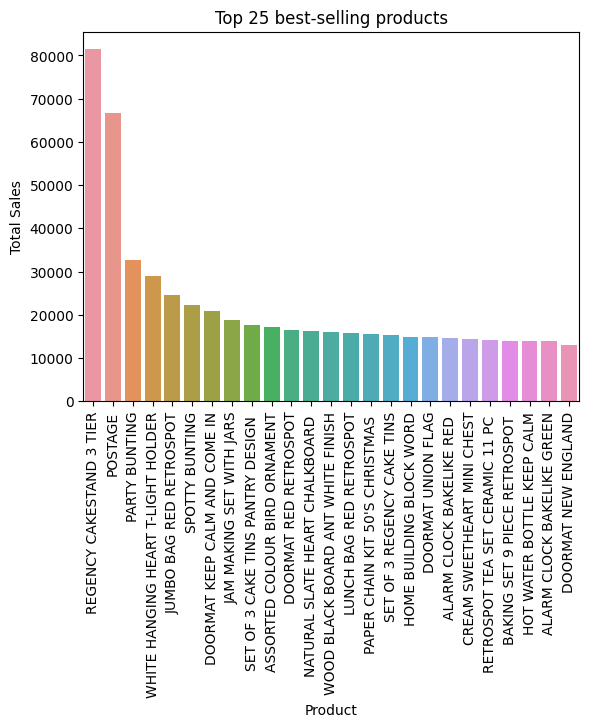

Worst 25 products:
                                     TotalPrice  Quantity  UnitPrice
Description                                                         
CHALKBOARD KITCHEN ORGANISER             -87.80      -4.0  21.950000
BROCADE RING PURSE                       -77.94     267.0  -0.291910
WHITE CHERRY LIGHTS                      -54.00      -8.0   6.750000
CREAM SWEETHEART MAGAZINE RACK           -46.85      -3.0  15.616667
WOODEN BOX ADVENT CALENDAR               -45.70      -6.0   7.616667
HANGING RIDGE GLASS T-LIGHT HOLDER       -40.56     -24.0   1.690000
PINK CHERRY LIGHTS                       -27.00      -4.0   6.750000
BLUE PADDED SOFT MOBILE                  -25.50      -6.0   4.250000
ANTIQUE LILY FAIRY LIGHTS                -14.85      -3.0   4.950000
CREAM SWEETHEART TRAYS                   -12.75      -1.0  12.750000
TEA TIME CAKE STAND IN GIFT BOX          -10.75      -1.0  10.750000
CREAM SWEETHEART SHELF + HOOKS            -7.95      -1.0   7.950000
3 WICK CHRISTMA

<function matplotlib.pyplot.show(close=None, block=None)>

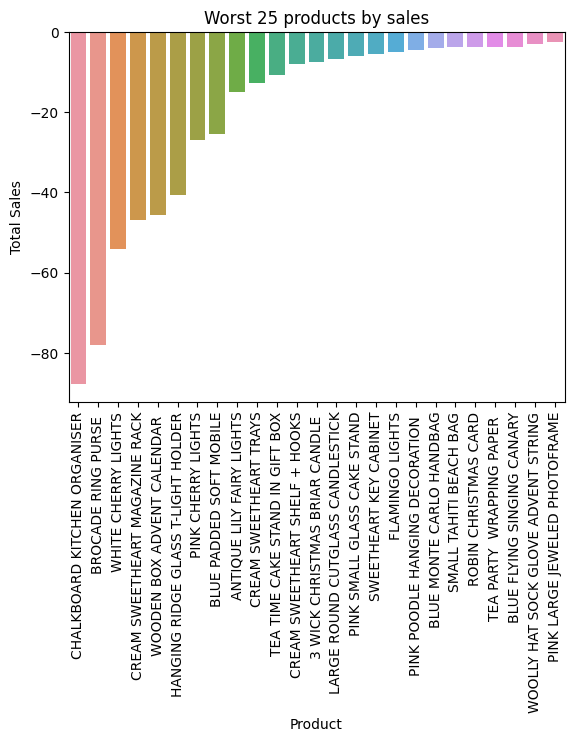

In [ ]:
#@title Best/Worst selling products (Attempt 1)
# Group the data by product and sum the total sales, quantity, and calculate the unit price for each product
ProductSummary = df.groupby("Description").agg({"TotalPrice": "sum", "Quantity": "sum"})
ProductSummary["UnitPrice"] = ProductSummary["TotalPrice"] / ProductSummary["Quantity"]

# Sort the products by total sales in descending order and select the top 25
BestProduct = ProductSummary.sort_values(by="TotalPrice", ascending=False).head(25)

# Print the top 25 products
print("Top 25 best-selling products:")
print(BestProduct)

# Plot the top 25 products and their sales
sns.barplot(x = BestProduct.index, y = "TotalPrice", data = BestProduct)
plt.title("Top 25 best-selling products")
plt.xlabel("Product")
plt.ylabel("Total Sales")
plt.xticks(rotation=90)
plt.show()

# Sort the products by total sales in ascending order and select the worst 25
WorstProduct = ProductSummary.sort_values(by="TotalPrice").head(25)

# Print the worst 25 products
print("Worst 25 products:")
# Prints in list format
print(WorstProduct)

# Plot the worst 25 products and their sales
sns.barplot(x = WorstProduct.index, y  ="TotalPrice", data = WorstProduct)
# Addint titles to the graoh
plt.title("Worst 25 products by sales")
plt.xlabel("Product")
plt.ylabel("Total Sales")
plt.xticks(rotation=90)
plt.show

In [ ]:
#@title Best/ Worst selling products (Attemtpt 2)
import plotly.graph_objects as go
import plotly.express as px

# Sort the products by total sales in descending order and select the top 25
BestProduct = ProductSummary.sort_values(by = "TotalPrice", ascending = False).head(25)

# Plot the top 25 products and their sales
fig = px.bar(BestProduct, x=BestProduct.index, y = "TotalPrice", hover_data = ["Quantity", "UnitPrice"])
fig.update_layout(
    title="Top 25 best-selling products",
    xaxis_title="Product",
    yaxis_title="Total Sales")

# Adding in colour code for graoh
fig.update_traces(marker=dict(color=px.colors.sequential.Greens))

fig.show()

# Sort the products by total sales in ascending order and select the worst 25
WorstProduct = ProductSummary.sort_values(by = "TotalPrice").head(45)

# Plot the worst 25 products and their sales
fig = px.bar(WorstProduct, x = WorstProduct.index, y="TotalPrice", hover_data=["Quantity", "UnitPrice"])
fig.update_layout(title = "Worst 25 products by sales", xaxis_title = "Product", yaxis_title = "Total Sales")

# Adding in colour code for graoh
fig.update_traces(marker = dict(color = px.colors.sequential.Reds))

fig.show()

In [ ]:
# Create own month and year column with pandas to see if month has any correlation with the data set
df["Year"] = pd.to_datetime(df["InvoiceDate"]).dt.year
df["Quarter"] = df.InvoiceDate.dt.quarter
df["Month"] = pd.to_datetime(df["InvoiceDate"]).dt.month
df["Week"] = pd.to_datetime(df["InvoiceDate"]).dt.isocalendar().week

In [ ]:

# Convert InvoiceDate to datetime type
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Create a new column IsWeekend based on the day of the week
df["IsWeekend"] = (df["InvoiceDate"].dt.dayofweek >= 5).astype(int)

In [ ]:
# To check it worked, uses bool to check if 1 which means yes it is weekend
weekend = df[df["IsWeekend"] == True]

# Check it worked
print(weekend)

       InvoiceNo StockCode                          Description  Quantity  \
7419      537037     22114    HOT WATER BOTTLE TEA AND SYMPATHY       8.0   
7420      537037     21485     RETROSPOT HEART HOT WATER BOTTLE       6.0   
7421      537037     22835      HOT WATER BOTTLE I AM SO POORLY       3.0   
7422      537037    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   
7423      537037    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
...          ...       ...                                  ...       ...   
524188    580536     21156            RETROSPOT CHILDRENS APRON       8.0   
524189    580536     21880                   RED RETROSPOT TAPE      12.0   
524190    580536     22090              PAPER BUNTING RETROSPOT       6.0   
524191    580536     22628     PICNIC BOXES SET OF 3 RETROSPOT        4.0   
524192    580536      POST                              POSTAGE       3.0   

               InvoiceDate  UnitPrice  CustomerID         Country        Da

In [ ]:
#@title Duplicates
# If row duplicated store here
Duplicates = df[df.duplicated(keep=False)]

# There were over 10,000 duplicates, if statement
if len(Duplicates) > 0:
  # Prints the length or count of duplicate rows
  print("Current count of duplicate rows:", len(Duplicates))
  # Droppin doubles
  df = df.drop_duplicates()
# If all duplicates missing or now deleted will show no duplicate found
else:
  print("No duplicate rows found to begin with.")

# If there are still duplicated rows
Duplicates2 = df[df.duplicated(keep=False)]

# There were over 10,000 duplicates, if statement
if len(Duplicates2) > 0:
  # Prints the length or count of duplicate rows
  print("Total count of duplicate rows after current count:", len(Duplicates2))
# If all duplicates missing or now deleted will show no duplicate found
else:
  print("No duplicate rows found, all have been deleted successfully.")

No duplicate rows found to begin with.
No duplicate rows found, all have been deleted successfully.


Encoding Data

In [ ]:
df.info()
PreDf = df.copy()
PreDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345679 entries, 0 to 541909
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         345679 non-null  object        
 1   StockCode         345679 non-null  object        
 2   Description       345679 non-null  object        
 3   Quantity          345679 non-null  float64       
 4   InvoiceDate       345679 non-null  datetime64[ns]
 5   UnitPrice         345679 non-null  float64       
 6   CustomerID        345679 non-null  float64       
 7   Country           345679 non-null  object        
 8   Date              345679 non-null  object        
 9   InvoiceTime       345679 non-null  object        
 10  TotalPrice        345679 non-null  float64       
 11  Transaction Type  345679 non-null  object        
 12  Year              345679 non-null  int64         
 13  Quarter           345679 non-null  int64         
 14  Mont

In [ ]:
# apply label encoding to the columns
df["StockCode"] = le.fit_transform(df["StockCode"])
df["Description"] = le.fit_transform(df["Description"])
df["Country"] = le.fit_transform(df["Country"])
df["Transaction Type"] = le.fit_transform(df["Transaction Type"])

# Sorting data types
df["Year"] = df["InvoiceDate"].dt.year
df["Date"] = df["InvoiceDate"].dt.day
df["Week"] = df["InvoiceDate"].dt.week
df["InvoiceTime"] = df["InvoiceDate"].dt.hour * 60 + df["InvoiceDate"].dt.minute


<ipython-input-196-3ba5db27b988>:10: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



In [ ]:

# Make Range between Max and min
AllDates = pd.date_range(start = StartDate, end = EndDate, freq = "D").date

# Dates between max and min
IncludedDates = df["InvoiceDate"].dt.date.unique()

# Dates not included in df
MissingDates = np.setdiff1d(AllDates, IncludedDates)

# All Missing Dates
print("Dates where there were no invoices sold:\n\n", MissingDates)

Dates where there were no invoices sold:

 [datetime.date(2010, 12, 4) datetime.date(2010, 12, 11)
 datetime.date(2010, 12, 18) datetime.date(2010, 12, 24)
 datetime.date(2010, 12, 25) datetime.date(2010, 12, 26)
 datetime.date(2010, 12, 27) datetime.date(2010, 12, 28)
 datetime.date(2010, 12, 29) datetime.date(2010, 12, 30)
 datetime.date(2010, 12, 31) datetime.date(2011, 1, 1)
 datetime.date(2011, 1, 2) datetime.date(2011, 1, 3)
 datetime.date(2011, 1, 8) datetime.date(2011, 1, 15)
 datetime.date(2011, 1, 22) datetime.date(2011, 1, 29)
 datetime.date(2011, 2, 5) datetime.date(2011, 2, 12)
 datetime.date(2011, 2, 19) datetime.date(2011, 2, 26)
 datetime.date(2011, 3, 5) datetime.date(2011, 3, 12)
 datetime.date(2011, 3, 19) datetime.date(2011, 3, 26)
 datetime.date(2011, 4, 2) datetime.date(2011, 4, 9)
 datetime.date(2011, 4, 16) datetime.date(2011, 4, 22)
 datetime.date(2011, 4, 23) datetime.date(2011, 4, 24)
 datetime.date(2011, 4, 25) datetime.date(2011, 4, 29)
 datetime.date(2011,

# Heatmap

<ipython-input-198-fa2a679b9333>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

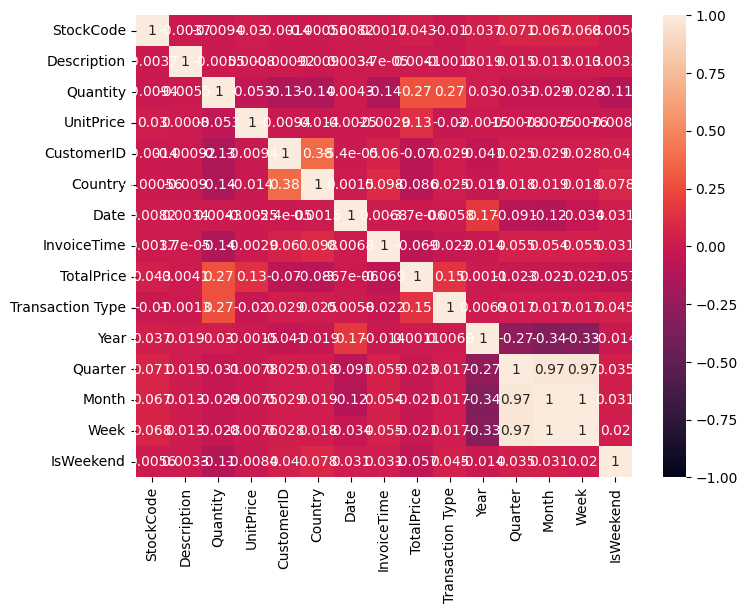

In [ ]:
# Heatmap, df.correlation anlaysis on whole df
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr(), vmin = -1, vmax = 1, annot = True)

In [ ]:

# Grouping columns and adding them based on the columns in brackets
grouped_df = df.groupby(["StockCode", "IsWeekend", "Date", "Year", "Month", "Week", "Country"]).agg({"TotalPrice": "sum", "Quantity": "sum"})

# Resets index
grouped_df = grouped_df.reset_index()

In [ ]:
grouped_df.isnull().sum()

StockCode     0
IsWeekend     0
Date          0
Year          0
Month         0
Week          0
Country       0
TotalPrice    0
Quantity      0
dtype: int64

# Data analysis (Sales)

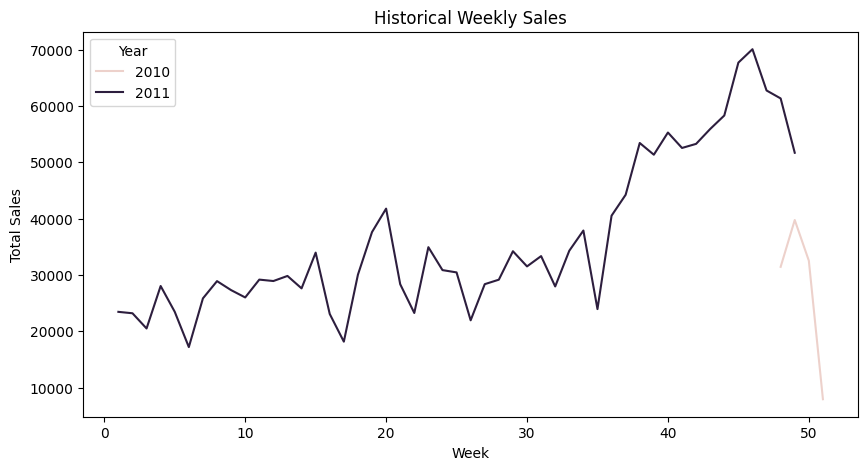

In [ ]:

# Compute the total monthly sales
WeeklySales = df.groupby(["Year", "Week"])["Quantity"].sum().reset_index()

# Plot the historical monthly sales with year hue
plt.figure(figsize=(10, 5))
sns.lineplot(x="Week", y="Quantity", hue="Year", data=WeeklySales)
plt.xlabel("Week")
plt.ylabel("Total Sales")
plt.title("Historical Weekly Sales")
plt.legend(title="Year")
plt.show()

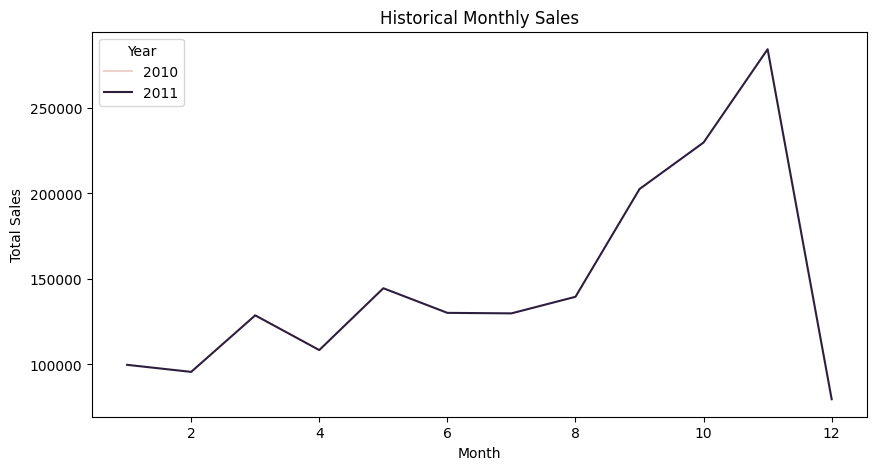

In [ ]:

# Compute the total monthly sales
MonthlySales = df.groupby(["Year", "Month"])["Quantity"].sum().reset_index()

# Plot the historical monthly sales with year hue
plt.figure(figsize=(10, 5))
sns.lineplot(x="Month", y="Quantity", hue ="Year", data=MonthlySales)
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Historical Monthly Sales")
plt.legend(title="Year")
plt.show()

<Axes: >

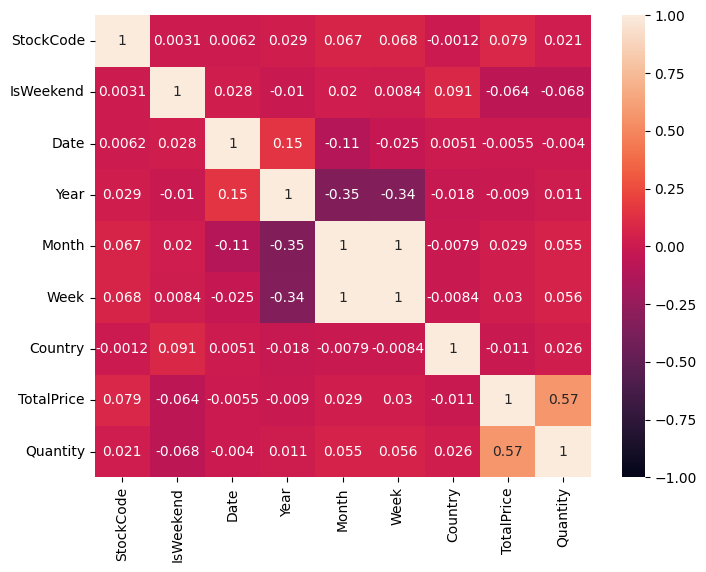

In [ ]:

# Heatmap, df.correlation anlaysis on whole df
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(grouped_df.corr(), vmin = -1, vmax = 1, annot = True)

In [ ]:
FullDf = df.copy()
df= df.drop(["CustomerID"], axis=1)
df= df.drop(["InvoiceNo"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345679 entries, 0 to 541909
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   StockCode         345679 non-null  int64         
 1   Description       345679 non-null  int64         
 2   Quantity          345679 non-null  float64       
 3   InvoiceDate       345679 non-null  datetime64[ns]
 4   UnitPrice         345679 non-null  float64       
 5   Country           345679 non-null  int64         
 6   Date              345679 non-null  int64         
 7   InvoiceTime       345679 non-null  int64         
 8   TotalPrice        345679 non-null  float64       
 9   Transaction Type  345679 non-null  int64         
 10  Year              345679 non-null  int64         
 11  Quarter           345679 non-null  int64         
 12  Month             345679 non-null  int64         
 13  Week              345679 non-null  int64         
 14  IsWe

# Train test split

In [ ]:
from sklearn.model_selection import train_test_split

# Dropping as no needed
X = df.drop(["InvoiceDate"],axis=1)

# Target Variable, predict sales
y = df.TotalPrice
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, shuffle=False)
print(X_train)
X_test.info()

        StockCode  Description  Quantity  UnitPrice  Country  Date  \
0            3179         3656       6.0       2.55       35     1   
1            2586         3664       6.0       3.39       35     1   
2            2787          845       8.0       2.75       35     1   
3            2735         1781       6.0       3.39       35     1   
4            2734         2725       6.0       3.39       35     1   
...           ...          ...       ...        ...      ...   ...   
411173       2469         3385       2.0       4.95       35    21   
411174        296         2777       2.0       0.95       35    21   
411175       1009          722       8.0       2.10       35    21   
411176       1008          724       2.0       1.45       35    21   
411177       1007          723       2.0       2.10       35    21   

        InvoiceTime  TotalPrice  Transaction Type  Year  Quarter  Month  Week  \
0               506       15.30                 1  2010        4     12    48 

# Machine Learning Algorithm 1 (Inventory Sales Forecasting)

In [ ]:
df.isnull().sum()

StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
Date                0
InvoiceTime         0
TotalPrice          0
Transaction Type    0
Year                0
Quarter             0
Month               0
Week                0
IsWeekend           0
dtype: int64

LinearRegression: RMSE=5.549684558650353e-14, R^2=1.0


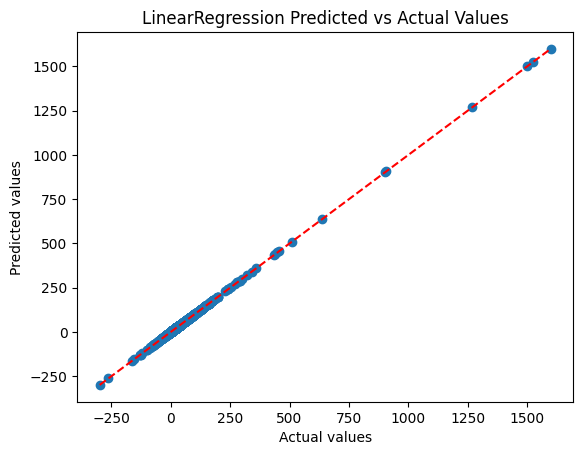

DecisionTreeRegressor: RMSE=4.183866421925934, R^2=0.946949446905569


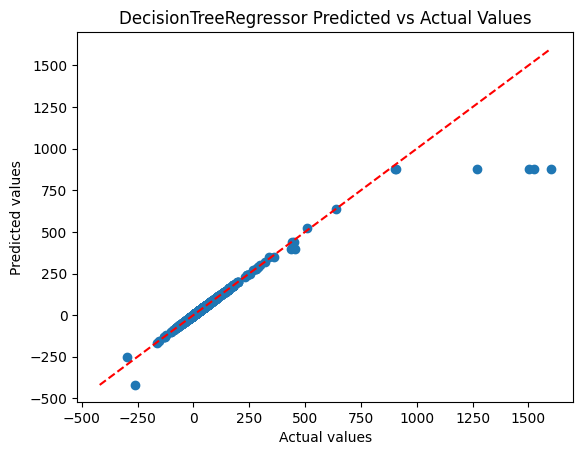

XGBRegressor: RMSE=6.442327157514049, R^2=0.8742176088300058


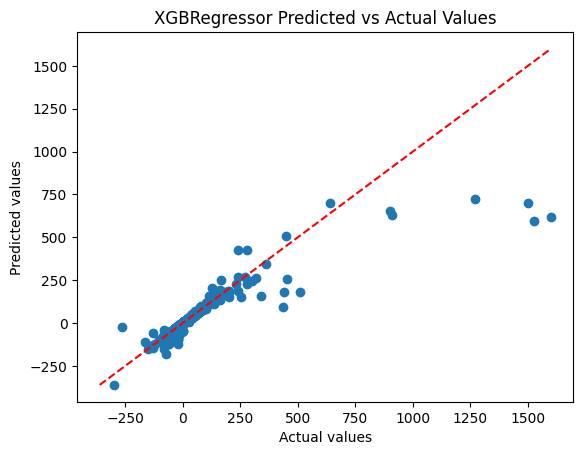

In [ ]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Trained and evaluated different regression models
models = [LinearRegression(), DecisionTreeRegressor(), XGBRegressor()]

# For loop to print over each model
for model in models:
    # Train
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_test)
    # Check accuracy RMSE and R^2 scores
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    print(f"{type(model).__name__}: RMSE={rmse}, R^2={r2}")

    # Calculate the forecasted values
    if isinstance(model, LinearRegression):
        forecast = model.predict(X_test)

    # Plot predicted vs actual valuess
    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    # Title wiht model name
    plt.title(f"{type(model).__name__} Predicted vs Actual Values")

    # Add a line diagonally to aid visulisation
    min_value = min(y_test.min(), y_pred.min())
    max_value = max(y_test.max(), y_pred.max())
    plt.plot([min_value, max_value], [min_value, max_value], "r--")
    plt.show()

In [ ]:
# library needed
from plotly.subplots import make_subplots

# Function to show graph
def ShowMe(date, true, preds):
    # Plots
    fig = make_subplots(rows=1, cols=1)

    # Adding the true values to the graph
    fig.add_trace(go.Scatter(x = date, y = true.iloc[:, 0], mode = "lines", marker = dict(color = "#783242"), name = "True"))
    # Addes forcasted values to the graph
    fig.add_trace(go.Scatter(x = date, y = preds.iloc[:, 0], mode="lines", name = "Preds"))

    # Tidying up the graph
    fig.update_layout(
        xaxis = dict(title = "Date"),
        yaxis = dict(title = "TotalPrice"),
        title = "Forecasted Values vs True Values"
    )

    fig.show()


In [ ]:
# If else codnition for graph with forcasted values ontop of actual
if isinstance(model, LinearRegression):
    forecast = model.predict(X_test.drop("forecast", axis=1))
else:
    forecast = model.predict(X_test)

# Created a new DataFrame for the forecasted values
ForecastDF = pd.DataFrame({"Date": X_test["Date"], "forecast": forecast})

# Combine the forecasted values with the historical data
CombinedDF = pd.concat([df, ForecastDF], ignore_index=True)

# Split the combined DataFrame into true and predicted values based on the splitter index
splitter = round(len(df) * 0.75)
true = CombinedDF.loc[splitter:, ["Date", "TotalPrice"]].groupby("Date").mean()
preds = CombinedDF.loc[splitter:, ["Date", "forecast"]].groupby("Date").mean()

# Plot the true and predicted values
ShowMe(true.index, true, preds)

In [ ]:
PreDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345679 entries, 0 to 541909
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         345679 non-null  object        
 1   StockCode         345679 non-null  object        
 2   Description       345679 non-null  object        
 3   Quantity          345679 non-null  float64       
 4   InvoiceDate       345679 non-null  datetime64[ns]
 5   UnitPrice         345679 non-null  float64       
 6   CustomerID        345679 non-null  float64       
 7   Country           345679 non-null  object        
 8   Date              345679 non-null  object        
 9   InvoiceTime       345679 non-null  object        
 10  TotalPrice        345679 non-null  float64       
 11  Transaction Type  345679 non-null  object        
 12  Year              345679 non-null  int64         
 13  Quarter           345679 non-null  int64         
 14  Mont

# Market basket analysis

In [ ]:
#@title Checking if there are orders with multiple products
# Stores dublicate InvoiceNo
DuplicateInvoices = PreDf[PreDf.duplicated(["InvoiceNo"], keep=False)]

# If duplicated prints count in pDuplicateInvoice
if len(DuplicateInvoices) > 0:
    print("Total count of duplicate InvoiceNo:", len(DuplicateInvoices["InvoiceNo"].unique()))
    # If non print non
else:
    print("No duplicate InvoiceNo found.")

Total count of duplicate InvoiceNo: 17206


In [ ]:
# Same but for InvoiceNo and Description, shos if potetioal for analysis
DuplicateInvoices = PreDf[PreDf.duplicated(["InvoiceNo", "Description"], keep=False)]

if len(DuplicateInvoices) > 0:
    duplicate_counts = DuplicateInvoices["InvoiceNo"].value_counts()
    # Counts total Invoices with different description
    count = sum(duplicate_counts >= 2)
    print("Count of invoices with 2 or more products based on different descriptions:", count)
else:
    print("No duplicate InvoiceNo found.")

Count of invoices with 2 or more products based on different descriptions: 1834


In [ ]:
DuplicateRows = PreDf[PreDf.duplicated(keep=False)]

if len(DuplicateRows) > 0:
    print("Total count of duplicate rows:", len(DuplicateRows))
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [ ]:
DuplicateInvoices = PreDf[PreDf.duplicated(["Description"], keep=False)]

if len(DuplicateInvoices) > 0:
    duplicate_counts = DuplicateInvoices["Description"].value_counts()
    count = sum(duplicate_counts >= 2)
    print("Count of invoices with the same description but different InvoiceNo:", count)
else:
    print("No duplicate invoices with the same description found.")

Count of invoices with the same description but different InvoiceNo: 3582


In [ ]:
#@title Aprori Algorithm (Recommended products result)

# basket or group
basket = (PreDf.groupby(["InvoiceNo", "Description"])["Quantity"]
          .sum().unstack().reset_index().fillna(0)
          .set_index("InvoiceNo"))

# Convert the quantity values to 0 or 1
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

# Apriori algorithm finds frequent itemsets, low min support as only a small % of sales can come here
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sort by descending order
rules = rules.sort_values(by = "confidence", ascending=False)

# Print the top 10 association rules
top_rules = rules.head(10)
print("Top 10 association rules:")
print(top_rules[["antecedents", "consequents", "support", "confidence", "lift"]])

# Gets the top items frequently together
top_items = top_rules["antecedents"].tolist() + top_rules["consequents"].tolist()
top_items = list(set(top_items))  # Remove duplicates

# Print the top items frequently together
print("\nTop items frequently paired together:\n")
if len(top_items) >= 2:
    for itemset in top_items:
        if len(itemset) >= 2:
            print(", ".join(itemset))
else:
    print("\nNo frequent itemsets with 2 or more items found.")

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



Top 10 association rules:
                                           antecedents  \
510  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...   
354  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
348  (PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
508  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...   
298                    (POPPY'S PLAYHOUSE LIVINGROOM )   
502  (PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
352  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...   
358  (GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...   
61                    (PINK REGENCY TEACUP AND SAUCER)   
296                       (POPPY'S PLAYHOUSE BEDROOM )   

                            consequents   support  confidence       lift  
510   (GREEN REGENCY TEACUP AND SAUCER)  0.010458    0.909091  30.222757  
354   (GREEN REGENCY TEACUP AND SAUCER)  0.016584    0.892761  29.679882  
348   (GREEN REGENCY TEACUP AND SAUCER)  0.012002    0.876364  29.134738  
508  (ROSES REGENCY TEACUP AND SAUC

# GUI

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, Image

# Load and prepare your data
data_path = '/content/drive/MyDrive/Bachelor/Data/online_retail_10_11.csv'
data = pd.read_csv(data_path)

# Replace 'total_sales' with the actual name of your sales/demand target column
X = data.drop('Total Sales', axis=1)
y = data['Total Sales']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)


# Display the logo
logo_path = '/content/drive/MyDrive/Bachelor/Images/Bachelor - Logo.png'
display(Image(filename=logo_path))

# GUI components
style = {'description_width': 'initial'}
layout = {'width': 'auto'}

time_period_widget = widgets.IntSlider(
    value=1, min=1, max=12, step=1, description='Time Period (Months):',
    style=style, layout=layout
)

product_category_widget = widgets.Dropdown(
    options=['Electronics', 'Clothing', 'Home & Garden', 'Toys & Games', 'Other'],
    value='Electronics', description='Product Category:',
    style=style, layout=layout
)

predict_button = widgets.Button(
    description='Predict Demand', button_style='info', icon='check',
    layout={'width': 'auto', 'height': 'auto'}
)

output_widget = widgets.Output(layout={'border': '1px solid #800080', 'width': '600px'})

# Prediction function
def predict_demand(time_period, product_category):
    # Prepare the input data for the model
    # Adjust this according to how your model was trained
    input_data = pd.DataFrame({
        'time_period': [time_period],
        'is_electronics': [product_category == 'Electronics'],
        'is_clothing': [product_category == 'Clothing'],
        'is_home_garden': [product_category == 'Home & Garden'],
        'is_toys_games': [product_category == 'Toys & Games'],
        'is_other': [product_category == 'Other']
    })

    prediction = linear_regression_model.predict(input_data)
    return prediction

# Event handler for the predict button
def on_predict_button_clicked(b):
    with output_widget:
        clear_output(wait=True)
        time_period = time_period_widget.value
        product_category = product_category_widget.value
        prediction = predict_demand(time_period, product_category)
        print(f"Predicted Demand for {product_category} over the next {time_period} month(s): {prediction[0]}")

predict_button.on_click(on_predict_button_clicked)

# Display the GUI
widgets.VBox([time_period_widget, product_category_widget, predict_button, output_widget])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyError: ignored